In [1]:
import torch
import pandas as pd
import numpy as np
import json
import random
import time
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import trange, tqdm
from sklearn import metrics
from data import preprocess as prep
from box_embeddings.parameterizations.box_tensor import *
from box_embeddings.modules.volume import bessel_volume_approx
from box_embeddings.modules.intersection import gumbel_intersection
from data.box_embedding import box_dataset, taxonomy_sampling
from utils.box_mlp import modelling, loss
from experiments import box_experiments
from torch.utils.data import RandomSampler, DataLoader, Subset

AllenNLP not available. Registrable won't work.


In [2]:
with open('./config.json') as inf1:
    config = json.load(inf1)
classlist = prep.load_ebay_taxonomy(config)
breadcrumb_table = {}
for i,row in prep.load_ebay_taxonomy({'data':{'raw_taxonomy_path': './data/2021-10-12', 'breadcrumb_link': 'symbol'}},pandas=True).iterrows():
    breadcrumb_table[row['catid']] = row['breadcrumb']
#data = taxonomy_sampling.informed_sampling(classlist, breadcrumb_table, nneg=168540, neg_screen=True, relax=2, holdout=0.1, transitive=True, save_dir='./data/box_embedding/taxonomy4.csv')
data = pd.read_csv('./data/box_embedding/taxonomy4.csv',dtype={'cat1':str,'cat2':str,'label':np.int64}).dropna()
train_data = data[(data['label']==0) | (data['label']==1)].reset_index(drop=True)
eval_data = data[(data['label']==2) | (data['label']==3)].copy().reset_index(drop=True)
eval_data['label'] = eval_data['label']-2
test_data = pd.read_csv('./data/test/subclass_golden_set.csv',dtype={'cat1':str,'cat2':str,'label_loose':np.int64,'label_strict':np.int64}).dropna()
with open('/data/ebay/data/jingcshi/features_8.json') as inf2:
    itemdata = json.load(inf2)
for cat in list(itemdata.keys()):
    vec = np.array(itemdata[cat])
    if np.any(np.isnan(vec)):
        itemdata.pop(cat)
    else:
        itemdata[cat] = vec
features = pd.Series(itemdata)
train_dataset = box_dataset.BoxEmbeddingDataset(train_data,features)
eval_dataset = box_dataset.BoxEmbeddingDataset(eval_data,features)
test_dataset = box_dataset.BoxEmbeddingDataset(test_data,features)
print(f'Training rows: {len(train_dataset):,}')
print(f'Validatation rows: {len(eval_dataset):,}')
print(f'Test rows: {len(test_dataset):,}')

Training rows: 207,790
Validatation rows: 16,705
Test rows: 128


In [21]:
BOX_DIM = 20
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 5e-5
BOX_TEMP = 0.01 #t 
SUBCLASS_THRESHOLD = 0.25

In [4]:
train_iterator = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)
eval_iterator = torch.utils.data.DataLoader(eval_dataset,shuffle=True,batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=BATCH_SIZE)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = modelling.MLP(input_dim=features[0].shape[0], output_dim=2*BOX_DIM, hidden_layers=4, hidden_dim=60).double().to(device)
#model.load_state_dict(torch.load('./utils/box_mlp/20220707-1426.pt'))
print(f'The model has {modelling.count_parameters(model):,} trainable parameters')
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

The model has 197,800 trainable parameters


In [14]:
best_eval_loss = float('inf')
training_stats = {'trainloss':[],'evalloss':[]}
for epoch in trange(EPOCHS):    
    if epoch == 0:
        eval_loss, eval_confusion = box_experiments.evaluate(model, eval_iterator, device, t=BOX_TEMP, threshold=SUBCLASS_THRESHOLD)
        eval_cm = box_experiments.build_confusion_matrix(eval_confusion)
        print(f'Initial state')
        print(f'\tEval Loss: {eval_loss:.6f} | Eval confusion matrix:')
        display(eval_cm)
        training_stats['evalloss'].append(eval_loss)
        
    start_time = time.monotonic()
    train_loss, train_confusion = box_experiments.train(model, train_iterator, optimizer, device, t=BOX_TEMP, threshold=SUBCLASS_THRESHOLD)
    train_cm = box_experiments.build_confusion_matrix(train_confusion)
    training_stats['trainloss'].append(train_loss)
    eval_loss, eval_confusion = box_experiments.evaluate(model, eval_iterator, device, t=BOX_TEMP, threshold=SUBCLASS_THRESHOLD)
    eval_cm = box_experiments.build_confusion_matrix(eval_confusion)
    training_stats['evalloss'].append(eval_loss)
    
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        torch.save(model.state_dict(), './utils/box_mlp/checkpoint.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = box_experiments.epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.6f} | Train confusion matrix:')
    display(train_cm)
    print(f'\tEval Loss: {eval_loss:.6f} | Eval confusion matrix:')
    display(eval_cm)

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Initial state
	Eval Loss: 0.801007 | Eval confusion matrix:


F1=0.1826, precision=0.1004, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                         15027                0

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 23s
	Train Loss: 0.215144 | Train confusion matrix:


F1=0.3904, precision=0.2425, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                        127381            39627

	Eval Loss: 0.106632 | Eval confusion matrix:


F1=0.2767, precision=0.1605, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          8774             6253

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 20s
	Train Loss: 0.084223 | Train confusion matrix:


F1=0.4806, precision=0.3163, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         88147            78861

	Eval Loss: 0.069724 | Eval confusion matrix:


F1=0.3131, precision=0.1856, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          7362             7665

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 19s
	Train Loss: 0.061282 | Train confusion matrix:


F1=0.4866, precision=0.3215, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         86059            80949

	Eval Loss: 0.060766 | Eval confusion matrix:


F1=0.3043, precision=0.1794, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          7674             7353

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 20s
	Train Loss: 0.049662 | Train confusion matrix:


F1=0.4723, precision=0.3092, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         91133            75875

	Eval Loss: 0.047893 | Eval confusion matrix:


F1=0.3027, precision=0.1783, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          7731             7296

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 21s
	Train Loss: 0.043893 | Train confusion matrix:


F1=0.4843, precision=0.3195, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         86866            80142

	Eval Loss: 0.045561 | Eval confusion matrix:


F1=0.2984, precision=0.1753, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          7892             7135

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 21s
	Train Loss: 0.039978 | Train confusion matrix:


F1=0.4874, precision=0.3222, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         85793            81215

	Eval Loss: 0.042453 | Eval confusion matrix:


F1=0.2994, precision=0.1760, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          7854             7173

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 21s
	Train Loss: 0.036741 | Train confusion matrix:


F1=0.4900, precision=0.3245, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         84895            82113

	Eval Loss: 0.039484 | Eval confusion matrix:


F1=0.3090, precision=0.1827, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          7505             7522

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 21s
	Train Loss: 0.033292 | Train confusion matrix:


F1=0.4985, precision=0.3320, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         82039            84969

	Eval Loss: 0.038756 | Eval confusion matrix:


F1=0.3136, precision=0.1859, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          7347             7680

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 20s
	Train Loss: 0.030729 | Train confusion matrix:


F1=0.5106, precision=0.3428, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         78179            88829

	Eval Loss: 0.035859 | Eval confusion matrix:


F1=0.3211, precision=0.1913, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          7094             7933

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 20s
	Train Loss: 0.028590 | Train confusion matrix:


F1=0.5237, precision=0.3547, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         74183            92825

	Eval Loss: 0.038743 | Eval confusion matrix:


F1=0.3240, precision=0.1933, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          7001             8026

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 1m 21s
	Train Loss: 0.027070 | Train confusion matrix:


F1=0.5361, precision=0.3662, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         70593            96415

	Eval Loss: 0.033483 | Eval confusion matrix:


F1=0.3442, precision=0.2079, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          6394             8633

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 31s
	Train Loss: 0.025869 | Train confusion matrix:


F1=0.5488, precision=0.3782, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         67057            99951

	Eval Loss: 0.038742 | Eval confusion matrix:


F1=0.3393, precision=0.2043, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          6536             8491

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 1m 28s
	Train Loss: 0.024663 | Train confusion matrix:


F1=0.5614, precision=0.3903, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         63718           103290

	Eval Loss: 0.034714 | Eval confusion matrix:


F1=0.3759, precision=0.2315, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          5571             9456

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 20s
	Train Loss: 0.023635 | Train confusion matrix:


F1=0.5725, precision=0.4011, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         60894           106114

	Eval Loss: 0.033661 | Eval confusion matrix:


F1=0.3756, precision=0.2313, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          5578             9449

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 1m 21s
	Train Loss: 0.022918 | Train confusion matrix:


F1=0.5810, precision=0.4094, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         58831           108177

	Eval Loss: 0.033952 | Eval confusion matrix:


F1=0.4084, precision=0.2566, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          4861            10166

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 20s
	Train Loss: 0.022268 | Train confusion matrix:


F1=0.5874, precision=0.4158, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         57289           109719

	Eval Loss: 0.031782 | Eval confusion matrix:


F1=0.3918, precision=0.2436, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          5209             9818

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 1m 20s
	Train Loss: 0.021677 | Train confusion matrix:


F1=0.5941, precision=0.4225, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         55735           111273

	Eval Loss: 0.032197 | Eval confusion matrix:


F1=0.3957, precision=0.2466, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          5126             9901

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 20s
	Train Loss: 0.021038 | Train confusion matrix:


F1=0.5992, precision=0.4277, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         54567           112441

	Eval Loss: 0.031564 | Eval confusion matrix:


F1=0.4035, precision=0.2527, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          4962            10065

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 1m 20s
	Train Loss: 0.020400 | Train confusion matrix:


F1=0.6084, precision=0.4372, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         52508           114500

	Eval Loss: 0.031540 | Eval confusion matrix:


F1=0.3991, precision=0.2493, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          5052             9975

Training:   0%|          | 0/12987 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 20s
	Train Loss: 0.019849 | Train confusion matrix:


F1=0.6129, precision=0.4418, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                      40782                0
label negative                                         51525           115483

	Eval Loss: 0.031817 | Eval confusion matrix:


F1=0.4193, precision=0.2653, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
label negative                                          4647            10380

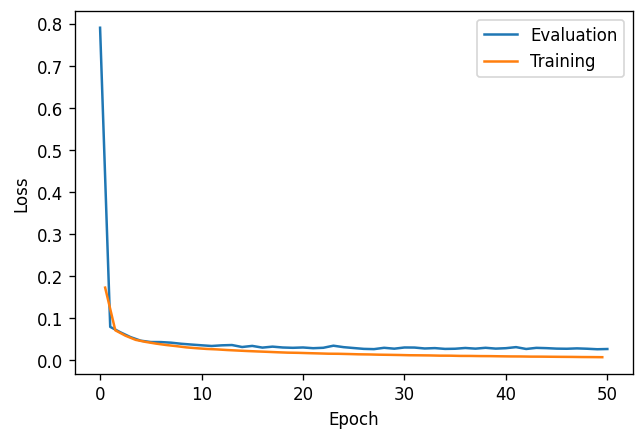

In [17]:
plot_loss_curve(training_stats)

In [6]:
def plot_loss_curve(stats):
    num_epochs = len(stats['trainloss'])
    xeval = np.linspace(0,num_epochs,num_epochs+1)
    xtrain = np.linspace(0.5,num_epochs-0.5,num_epochs)
    fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
    evalcurve = ax.plot(xeval,stats['evalloss'],label='Evaluation')
    traincurve = ax.plot(xtrain,stats['trainloss'],label='Training')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    plt.show()

In [7]:
def Softbox_loss(y1, y2, d, t, label, device, subclass_threshold=0):
    
    inf1 = y1[:d]-y1[d:]/2
    sup1 = y1[:d]+y1[d:]/2
    inf2 = y2[:d]-y2[d:]/2
    sup2 = y2[:d]+y2[d:]/2
    box1 = BoxTensor(torch.stack([inf1,sup1],dim=0))
    box2 = BoxTensor(torch.stack([inf2,sup2],dim=0))
    
    intersection = gumbel_intersection(box1,box2,intersection_temperature=t)
    logvchild = bessel_volume_approx(box1,volume_temperature=t,intersection_temperature=t)
    logvint = bessel_volume_approx(intersection,volume_temperature=t,intersection_temperature=t)
    logp = (logvint - logvchild).clamp(min=-5*d,max=-np.exp(-5*d))
    logn = torch.log(1-torch.exp(logp))
    
    L = label * -logp + (1-label) * -logn + torch.relu(-d-logvchild)
    pred = logp >= np.log(subclass_threshold) * d
    
    return L, pred

In [8]:
def examine_box(dataset,features,c1=None,c2=None,label=None,print_info=True,eps=1e-10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if c1 == None:
        if label == None:
            sample = dataset[random.randrange(len(dataset))]
            c1 = sample['cat1']
            c2 = sample['cat2']
            label = sample['label']
        else:
            sample = dataset[random.randrange(len(dataset))]
            while (sample['label'] != label):
                sample = dataset[random.randrange(len(dataset))]
            c1 = sample['cat1']
            c2 = sample['cat2']
    if c2 == None:
        if print_info: print(f'Category: {c1}')
        x = torch.tensor(features[str(c1)]).to(device)
        y = model(x).detach().view(2,-1)
        inf = y[0]-y[1]/2
        sup = y[0]+y[1]/2
        box = BoxTensor(torch.stack([inf, sup],dim=0))
        vol = bessel_volume_approx(box,volume_temperature=BOX_TEMP,intersection_temperature=BOX_TEMP)
        if print_info: print(f'Box log-volume: {vol:.6f}')
        if print_info: print(f'Box inf:{box.z}')
        if print_info: print(f'Box sup:{box.Z}')
        return None, None
    else:
        if print_info: print(f'Category 1: {c1}\nCategory 2: {c2}')
        x1 = torch.tensor(features[str(c1)]).to(device)
        x2 = torch.tensor(features[str(c2)]).to(device)
        y1 = model(x1).detach().view(2,-1)
        y2 = model(x2).detach().view(2,-1)
        if label != None:
            if print_info: print(f"Label: {label}")
        inf1 = y1[0]-y1[1]/2
        sup1 = y1[0]+y1[1]/2
        inf2 = y2[0]-y2[1]/2
        sup2 = y2[0]+y2[1]/2
        box1 = BoxTensor(torch.stack([inf1, sup1],dim=0))
        box2 = BoxTensor(torch.stack([inf2, sup2],dim=0))
        vol1 = bessel_volume_approx(box1,volume_temperature=BOX_TEMP,intersection_temperature=BOX_TEMP)
        vol2 = bessel_volume_approx(box2,volume_temperature=BOX_TEMP,intersection_temperature=BOX_TEMP)
        intersection = gumbel_intersection(box1,box2,intersection_temperature=BOX_TEMP)
        volint = bessel_volume_approx(intersection,volume_temperature=BOX_TEMP,intersection_temperature=BOX_TEMP)
        overlap = torch.exp(volint - vol1)
        if label != None:
            L,_ = Softbox_loss(torch.cat((y1[0],y1[1])),torch.cat((y2[0],y2[1])),BOX_DIM,BOX_TEMP,label,device)
            if print_info: print(f"Loss: {L:.6f}")
        if print_info: print(f"Box 1 log-volume: {vol1:.6f}\nBox 2 log-volume: {vol2:.6f}")
        if print_info: print(f"Intersection log-volume: {volint:.6f}")
        if print_info: print(f"Proportional overlap: {overlap:.6f}")
        if print_info: print(f'Box1 inf:{box1.z}')
        if print_info: print(f'Box1 sup:{box1.Z}')
        if print_info: print(f'Box2 inf:{box2.z}')
        if print_info: print(f'Box2 sup:{box2.Z}')
        print(f'Intersection inf:{intersection.z}')
        print(f'Intersection sup:{intersection.Z}')
    return overlap

In [38]:
c1=57988
c2=1059
label=1
overlap = examine_box(train_dataset,features,c1=c1,c2=c2,label=label)

Category 1: 57988
Category 2: 1059
Label: 1
Loss: 0.001410
Box 1 log-volume: -16.303173
Box 2 log-volume: -6.195166
Intersection log-volume: -16.304583
Proportional overlap: 0.998591
Box1 inf:tensor([ 4.9616e-01,  2.8681e-02, -3.5793e-01,  3.6517e-01,  5.9801e-01,
         5.1277e-01,  7.5380e-01,  6.0325e-01,  8.4264e-01,  6.0340e-01,
         9.1169e-02,  1.0993e-04, -3.7751e-01,  5.9547e-01, -3.4919e-01,
         4.7291e-01,  3.9901e-01, -2.2483e-01, -2.2425e-02,  5.8802e-01],
       device='cuda:0', dtype=torch.float64)
Box1 sup:tensor([1.1192, 0.5757, 0.4110, 1.1332, 1.2761, 1.1740, 0.8588, 1.3843, 0.8707,
        1.3733, 0.8842, 0.6987, 0.4165, 1.3935, 0.4178, 1.0857, 0.4312, 0.4466,
        0.6013, 1.3764], device='cuda:0', dtype=torch.float64)
Box2 inf:tensor([ 0.4187, -0.1151, -0.4326,  0.2931,  0.5150,  0.4376,  0.6450,  0.5322,
         0.7271,  0.5312,  0.0565, -0.1280, -0.4470,  0.5302, -0.4243,  0.3880,
         0.3331, -0.3219, -0.1320,  0.5227], device='cuda:0',
       

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


In [33]:
model.load_state_dict(torch.load('./utils/box_mlp/20220707-1426.pt'))
eval_loss, eval_confusion = box_experiments.evaluate(model, eval_iterator, device, t=BOX_TEMP, threshold=SUBCLASS_THRESHOLD)
eval_cm = box_experiments.build_confusion_matrix(eval_confusion)
print(f'After training')
print(f'\tEval Loss: {eval_loss:.6f} | Eval confusion matrix:')
display(eval_cm)

Evaluating:   0%|          | 0/1045 [00:00<?, ?it/s]

After training
	Eval Loss: 0.026321 | Eval confusion matrix:


F1=0.5634, precision=0.3921, recall=1.0000                 
                                         Predict subsumption Predict negative
Label subsumption                                       1678                0
Label negative                                          2601            12426

In [29]:
now = datetime.now()
timestr = now.strftime('%Y%m%d-%H%M')
with open(f'./experiments/box_training_stats/{timestr}.json', 'w') as outf:
    outf.write(json.dumps(training_stats))

In [30]:
now = datetime.now()
timestr = now.strftime('%Y%m%d-%H%M')
torch.save(model.state_dict(), f'./utils/box_mlp/{timestr}.pt')

In [26]:
test_results,test_confusion = box_experiments.test(model, test_iterator, device, t=BOX_TEMP, threshold=SUBCLASS_THRESHOLD)
test_cm = box_experiments.build_confusion_matrix(test_confusion)
print(f'Test results:')
display(test_cm)
display(test_results)

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Test results:


F1=0.6364, precision=0.5333, recall=0.7887                 
                                         Predict subsumption Predict negative
Label subsumption                                         56               15
Label negative                                            49                8

,cat1,cat2,label,prediction
0,261260,107578,1,0
1,170098,261634,0,0
2,177851,185101,0,1
3,182060,28176,1,0
4,261697,262382,1,1
...,...,...,...,...
123,22653,159898,0,1
124,22966,118985,0,1
125,13756,261984,0,1
126,261672,262378,0,1


In [25]:
import sys
package_name = 'experiments'
loaded_package_modules = [key for key, value in sys.modules.items() if package_name in str(value)]
for key in loaded_package_modules:
        print(key)
        del sys.modules[key]
from experiments import box_experiments

experiments
experiments.box_experiments


In [31]:
train_data[train_data['cat1']=='175781']

,cat1,cat2,label
1061,175781,182044,1
18942,175781,260033,1
24841,175781,11450,1
38335,175781,175759,1
64555,175781,262354,0
75399,175781,834,0
80779,175781,183365,0
88101,175781,175698,0
146642,175781,153797,0
155338,175781,164804,0
